https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/08-deep-learning/homework.md

In the homework, we'll train a model from scratch

The dataset contains around 1000 images of hairs in the separate folders for training and test sets. (https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Model

For this homework we will use Convolutional Neural Network (CNN). We'll use PyTorch.

You need to develop the model with following structure:

* The shape for input should be `(3, 200, 200)` (channels first format in PyTorch)
* Next, create a convolutional layer (`nn.Conv2d`):
    * Use 32 filters (output channels)
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling (`nn.MaxPool2d`)
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using `flatten` or `view`
* Next, add a `nn.Linear` layer with 64 neurons and `'relu'` activation
* Finally, create the `nn.Linear` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use `torch.optim.SGD` with the following parameters:

* `torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)`

In [4]:
class CNNModel(nn.Module):
    """
    CNN for binary classification of images.
    Input shape: (batch_size, 3, 200, 200)
    """
    
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional layer: 32 filters, 3x3 kernel
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=(3, 3)
        )
        
        # Max pooling layer: 2x2 pooling size
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        
        # ReLU activation
        self.relu = nn.ReLU()
        
        # Calculate flatten size:
        # Input: (3, 200, 200)
        # After Conv2d(3, 32, kernel=3): (32, 198, 198)  -> (200 - 3 + 1 = 198)
        # After MaxPool2d(2): (32, 99, 99)  -> (198 // 2 = 99)
        # Flatten: 32 * 99 * 99 = 313632
        flatten_size = 32 * 99 * 99
        
        # Fully connected layer with 64 neurons
        self.fc1 = nn.Linear(flatten_size, 64)
        
        # Output layer with 1 neuron for binary classification
        self.fc2 = nn.Linear(64, 1)
        
        # Sigmoid activation for binary classification output
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Convolutional layer with ReLU activation
        x = self.conv1(x)
        x = self.relu(x)
        
        # Max pooling
        x = self.pool(x)
        
        # Flatten the feature maps
        x = x.view(x.size(0), -1)
        
        # Fully connected layer with ReLU activation
        x = self.fc1(x)
        x = self.relu(x)
        
        # Output layer with sigmoid activation
        x = self.fc2(x)
        # x = self.sigmoid(x)
        
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Create the model instance
model = CNNModel().to(device)

In [7]:
# Create the optimizer with specified parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

### Question 1

Which loss function you will use?

1. __Binary Classification:__ The model has 1 output neuron with sigmoid activation, producing probabilities between 0 and 1. 

2. __Output Activation:__ Since we're using sigmoid activation in the model itself, we should use `nn.BCELoss()` (`Binary Cross Entropy`). However, `nn.BCEWithLogitsLoss()` combines sigmoid activation and BCELoss in a single, more numerically stable operation.

Why not the others:

* `nn.MSELoss()`: Mean Squared Error is typically used for regression, not classification

* `nn.CrossEntropyLoss()`: This is for multi-class classification (multiple classes, not binary)

* `nn.CosineEmbeddingLoss()`: This is for measuring similarity between two inputs, not for binary classification

So the correct choice is `nn.BCEWithLogitsLoss()`.

In [8]:
criterion = nn.BCEWithLogitsLoss().to(device)

If you use `BCELoss`, you need to apply sigmoid activation because `BCELoss` expects probability values (between 0 and 1).

If you use `BCEWithLogitsLoss`, you should NOT apply sigmoid in your model because `BCEWithLogitsLoss` applies sigmoid internally.

### Question 2

What's the total number of parameters of the model?

#### Option 1: Using torchsummary

In [9]:
from torchsummary import summary

In [10]:
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
            Linear-4                   [-1, 64]      20,072,512
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 21.54
Params size (MB): 76.57
Estimated Total Size (MB): 98.57
----------------------------------------------------------------


#### Option 2: Manual counting

In [11]:
print("Parameter count per layer:")
print("-" * 50)

for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

print("-" * 50)
total = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total:,}")

Parameter count per layer:
--------------------------------------------------
conv1.weight: 864
conv1.bias: 32
fc1.weight: 20,072,448
fc1.bias: 64
fc2.weight: 64
fc2.bias: 1
--------------------------------------------------
Total parameters: 20,073,473


### Generators and Training

For the next two questions, use the following transformation for both train and test sets:

In [12]:
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

* We don't need to do any additional pre-processing for the images.
* Use `batch_size=20`
* Use `shuffle=True` for both training, but `False` for test. 

In [13]:
# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root='data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='data/test', transform=val_transforms)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")
print(f"Class to index: {train_dataset.class_to_idx}")

Training samples: 800
Validation samples: 201
Classes: ['curly', 'straight']
Class to index: {'curly': 0, 'straight': 1}


In [14]:
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs=10, device='cpu'):

    history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item() * images.size(0)
            # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
    
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct_train / total_train
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
    
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
    
                outputs = model(images)
                loss = criterion(outputs, labels)
    
                val_running_loss += loss.item() * images.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
    
        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = correct_val / total_val
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
    
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    
    return model, history

In [16]:
num_epochs = 10
model, history = train_and_evaluate(model,  optimizer, train_loader, val_loader, criterion, num_epochs,device)

Epoch 1/10, Loss: 0.6665, Acc: 0.5988, Val Loss: 0.6384, Val Acc: 0.6667
Epoch 2/10, Loss: 0.5694, Acc: 0.6787, Val Loss: 0.6148, Val Acc: 0.6716
Epoch 3/10, Loss: 0.5131, Acc: 0.7312, Val Loss: 0.6172, Val Acc: 0.6716
Epoch 4/10, Loss: 0.4732, Acc: 0.7588, Val Loss: 0.6053, Val Acc: 0.6766
Epoch 5/10, Loss: 0.4622, Acc: 0.7500, Val Loss: 0.7091, Val Acc: 0.6418
Epoch 6/10, Loss: 0.3856, Acc: 0.8300, Val Loss: 0.6575, Val Acc: 0.7015
Epoch 7/10, Loss: 0.2871, Acc: 0.8800, Val Loss: 0.8436, Val Acc: 0.6468
Epoch 8/10, Loss: 0.2794, Acc: 0.8725, Val Loss: 0.6556, Val Acc: 0.6816
Epoch 9/10, Loss: 0.1978, Acc: 0.9237, Val Loss: 1.0445, Val Acc: 0.6617
Epoch 10/10, Loss: 0.3276, Acc: 0.8638, Val Loss: 0.8743, Val Acc: 0.7363


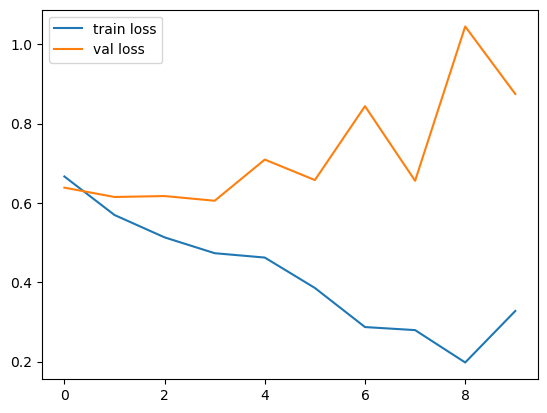

In [19]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()

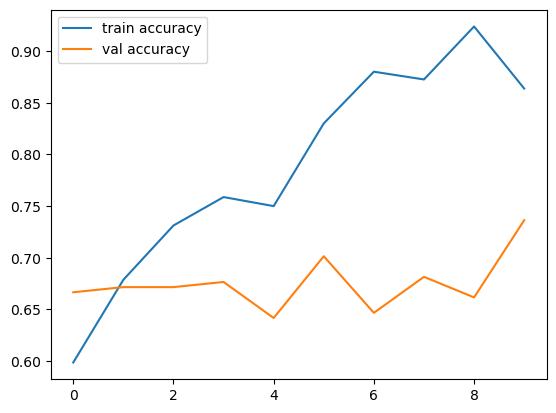

In [20]:
plt.plot(history['acc'], label='train accuracy')
plt.plot(history['val_acc'], label='val accuracy')
plt.legend()

### Question 3

What is the median of training accuracy for all the epochs for this model?

In [21]:
np.median(history['acc'])

np.float64(0.794375)

Ans: 0.84

### Question 4

What is the standard deviation of training loss for all the epochs for this model?

In [23]:
np.std(history['loss'])

np.float64(0.13882814106420327)

Ans: 0.171

### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

```python
transforms.RandomRotation(50),
transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
transforms.RandomHorizontalFlip(),
```

In [24]:
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])


# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root='data/train', transform=train_transforms)


### Question 5 

Let's train our model for 10 more epochs using the same code as previously.

> **Note:** make sure you don't re-create the model.
> we want to continue training the model we already started training.


In [25]:
model, history = train_and_evaluate(model,  optimizer, train_loader, val_loader, criterion, num_epochs,device)

Epoch 1/10, Loss: 0.1580, Acc: 0.9325, Val Loss: 0.8394, Val Acc: 0.7313
Epoch 2/10, Loss: 0.1244, Acc: 0.9550, Val Loss: 0.8804, Val Acc: 0.7413
Epoch 3/10, Loss: 0.0783, Acc: 0.9838, Val Loss: 0.8828, Val Acc: 0.7214
Epoch 4/10, Loss: 0.0903, Acc: 0.9712, Val Loss: 1.0855, Val Acc: 0.6816
Epoch 5/10, Loss: 0.0462, Acc: 0.9938, Val Loss: 1.0176, Val Acc: 0.7413
Epoch 6/10, Loss: 0.0221, Acc: 1.0000, Val Loss: 1.0235, Val Acc: 0.7363
Epoch 7/10, Loss: 0.0171, Acc: 1.0000, Val Loss: 1.0874, Val Acc: 0.7662
Epoch 8/10, Loss: 0.0097, Acc: 1.0000, Val Loss: 1.1479, Val Acc: 0.7463
Epoch 9/10, Loss: 0.0069, Acc: 1.0000, Val Loss: 1.2470, Val Acc: 0.7313
Epoch 10/10, Loss: 0.0059, Acc: 1.0000, Val Loss: 1.1566, Val Acc: 0.7612


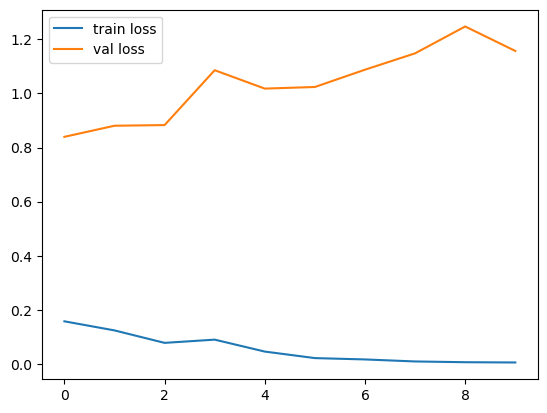

In [26]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()

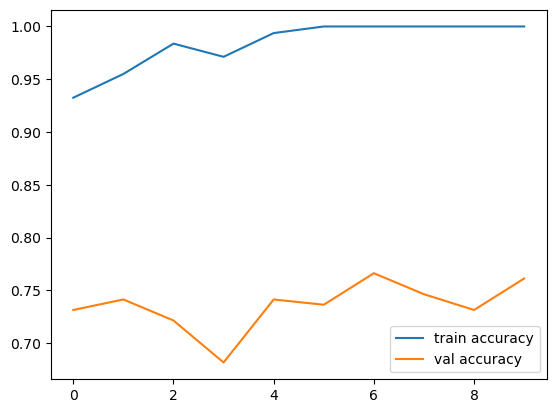

In [27]:
plt.plot(history['acc'], label='train accuracy')
plt.plot(history['val_acc'], label='val accuracy')
plt.legend()

What is the mean of test loss for all the epochs for the model trained with augmentations?

In [28]:
np.mean(history['val_loss'])

np.float64(1.036817413223855)

Ans: 0.88

### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

In [29]:
np.mean(history['val_acc'][-5:])

np.float64(0.7482587064676617)

Ans: 0.68